# G5 Project---Traffic sign recognition

##### Yue Chang (872301)

### Step 1. Preparation

1. Download dataset of German Traffic Sign Recognition Benchmark(GTSRB).(http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads)
Which is a popular dataset for training and testing model of traffic sign recognition.

2. Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import pandas as pd
import csv
import cv2
import math
import imutils
from PIL import Image
from skimage import exposure, feature, transform, color

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import scipy
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

3. Define useful functions, referenced from GTSRB's example code.(http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads) 

In [3]:
# helper functions 

# function for reading the images
# arguments: path to the traffic sign data, for example '../../GTSRB/train/Final_Training/Images/'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example '../dataset/GTSRB/train/Final_Training/Images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


def format_time(seconds):
        if seconds < 400:
            s = float(seconds)
            return "%.1f seconds" % (s,)
        elif seconds < 4000:
            m = seconds / 60.0
            return "%.2f minutes" % (m,)
        else:
            h = seconds / 3600.0
            return "%.2f hours" % (h,)

4. load training images

In [4]:
if os.path.isfile("trainImages.npy") &  os.path.isfile("trainLabels.npy") :
    X = np.load("trainImages.npy")
    y = np.load("trainLabels.npy")
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:    
    # training images and labels
    trainImages, trainLabels = readTrafficSigns('C:\AUS\semester 5\img processing\project\GTSRB_Final_Training_Images\GTSRB\Final_Training\Images')
    np.save("trainImages.npy",trainImages)
    np.save("trainLabels.npy",trainLabels)
    print("[INFO] training images and labels are read from the dataset directory")
    print("[INFO] training images saved to trainingImages.npy for further use")
    print("[INFO] training labels saved to trainingLabels.npy for further use")
    X = np.load("trainImages.npy")
    y = np.load("trainLabels.npy")
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))

[INFO] Training images and labels are loaded in variables ==> X,y
[INFO] Number of training Images 39209 
Number of Labels 39209


### Step 2. Cartesian to log-polar

In [5]:
def cart_to_log_polar(img,T):
    img = img.astype(np.float32)
    h, w = img.shape[:2]
    maxRadius = math.hypot(w/2,h/2)
    m = w / math.log(maxRadius)
    polar_img = cv2.logPolar(img,(w/2, h/2), m/T, cv2.WARP_FILL_OUTLIERS+ cv2.INTER_LINEAR)
    return polar_img

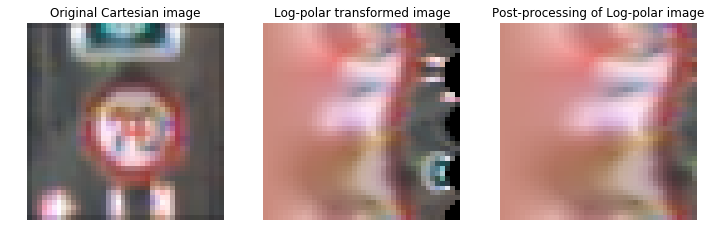

In [6]:
# example of cartesian and log-polar image
n = np.random.randint(0,len(X))
i1 = X[n]
grayim = i1
# grayim = color.rgb2gray(i1)
gI1 = transform.resize(grayim,(40,40))
gI2 = cart_to_log_polar(gI1,1)
gI3 = cart_to_log_polar(gI1,0.8)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(gI1)
ax1.set_title('Original Cartesian image')
ax1.set_adjustable('box-forced')
ax2.axis('off')
ax2.imshow(gI2, cmap=plt.cm.gray)
ax2.set_title('Log-polar transformed image')
ax2.set_adjustable('box-forced')
ax3.axis('off')
ax3.imshow(gI3, cmap=plt.cm.gray)
ax3.set_title('Post-processing of Log-polar image')
ax3.set_adjustable('box-forced')
plt.show()

### Step 3. Features extraction

#### 1. Histogram of Oriented Gradients (HOG)

In [7]:
def extract_HOG(img):
    (H, hog_img) = feature.hog(img, orientations=9, pixels_per_cell=(5,5),
    cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
    hog_img = exposure.rescale_intensity(hog_img, out_range=(0, 255)).astype("uint8")
    return H,hog_img   

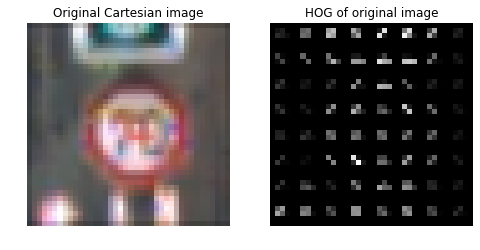

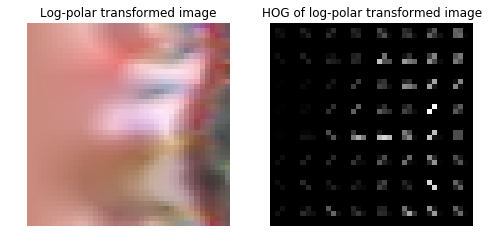

(1764,)
(1764,)


In [8]:
img = gI1
H1, hog_img = extract_HOG(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(img)
ax1.set_title('Original Cartesian image')
ax1.set_adjustable('box-forced')
ax2.axis('off')
ax2.imshow(hog_img, cmap=plt.cm.gray)
ax2.set_title('HOG of original image')
ax1.set_adjustable('box-forced')
plt.show()

log_img = gI3
H2, log_hog_img = extract_HOG(log_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(log_img)
ax1.set_title('Log-polar transformed image')
ax1.set_adjustable('box-forced')
ax2.axis('off')
ax2.imshow(log_hog_img, cmap=plt.cm.gray)
ax2.set_title('HOG of log-polar transformed image')
ax1.set_adjustable('box-forced')
plt.show()
print(H1.shape)
print(H2.shape)

#### 2. Local Binary Pattern (LBP)

In [9]:
def extract_LBP(img):
    rows, cols = img.shape
    radius = 2
    n_points = radius * 8
    lbp_sum=[]
    rows_ = rows+(6-rows%6)
    cols_ = cols+(6-cols%6)
    I1 = np.zeros((rows_,cols_))
    I1[0:rows,0:cols] = img
    for i in range(6):
        for j in range(6):
            img_block = I1[7*i:7*(i+1),7*j:7*(j+1)]
            lbp = feature.local_binary_pattern(img_block, n_points, radius, 'uniform')
            lbp2 = lbp.astype(np.int32)
            max_bins = 59
            train_hist, _ = np.histogram(lbp2.ravel(), normed=True, bins=max_bins, range=(0, max_bins))
            lbp_sum=lbp_sum + train_hist.tolist()
    lbp_sum = np.array(lbp_sum)          
    return lbp_sum

(2124,)


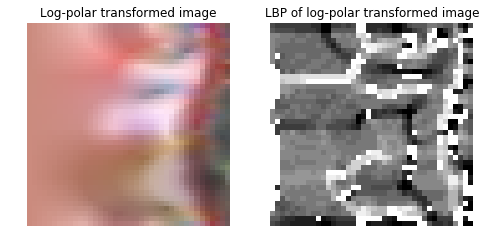

In [10]:
gI1 = color.rgb2gray(gI1)
gI1 = cart_to_log_polar(gI1,0.8)
lbp = extract_LBP(gI1)
print(lbp.shape)
radius = 2
n_points = radius * 8
lbp2 = feature.local_binary_pattern(gI1, n_points, radius, 'uniform')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(log_img)
ax1.set_title('Log-polar transformed image')
ax1.set_adjustable('box-forced')
ax2.axis('off')
ax2.imshow(lbp2, cmap=plt.cm.gray)
ax2.set_title('LBP of log-polar transformed image')
ax1.set_adjustable('box-forced')
plt.show()

### Step 4. Prepare train & test data

#### 1. HoG features' extraction

In [11]:
if os.path.isfile("HoGfeatures.npy"):
    print("[INFO] loading from file ... ")
    hogfeat = np.load("HoGfeatures.npy")    
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat")
else:
    print("[INFO] HoGfeatures.npy does not found")
    start_time = datetime.datetime.now()
    Hfeat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = color.rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))
        grayim = cart_to_log_polar(grayim,0.8)
        (H_4x4, hogImage) = extract_HOG(grayim)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGfeatures.npy", Hfeat)
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)    
    print("[INFO] HoGfeatures.npy are saved")
    print("total_time",t)
    print("[INFO] loading from file ... ")
    hogfeat = np.load("HoGfeatures.npy")    
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat")

[INFO] HoGfeatures.npy does not found
[INFO] processed 1000/39209
[INFO] processed 2000/39209
[INFO] processed 3000/39209
[INFO] processed 4000/39209
[INFO] processed 5000/39209
[INFO] processed 6000/39209
[INFO] processed 7000/39209
[INFO] processed 8000/39209
[INFO] processed 9000/39209
[INFO] processed 10000/39209
[INFO] processed 11000/39209
[INFO] processed 12000/39209
[INFO] processed 13000/39209
[INFO] processed 14000/39209
[INFO] processed 15000/39209
[INFO] processed 16000/39209
[INFO] processed 17000/39209
[INFO] processed 18000/39209
[INFO] processed 19000/39209
[INFO] processed 20000/39209
[INFO] processed 21000/39209
[INFO] processed 22000/39209
[INFO] processed 23000/39209
[INFO] processed 24000/39209
[INFO] processed 25000/39209
[INFO] processed 26000/39209
[INFO] processed 27000/39209
[INFO] processed 28000/39209
[INFO] processed 29000/39209
[INFO] processed 30000/39209
[INFO] processed 31000/39209
[INFO] processed 32000/39209
[INFO] processed 33000/39209
[INFO] process

#### 2. LBP features' extraction

In [11]:
if os.path.isfile("LBPfeatures.npy"):
    print("[INFO] loading from file ... ")
    lbpfeat = np.load("LBPfeatures.npy")    
    print("LBP features are loaded from LBPfeatures.npy to variable ==> lbpfeat")
else:
    print("[INFO] LBPfeatures.npy does not found")
    start_time = datetime.datetime.now()
    Lfeat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = color.rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))
        grayim = cart_to_log_polar(grayim,0.8)
        lbp = extract_LBP(grayim)
        Lfeat.append(lbp)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("LBPfeatures.npy", Lfeat)
#     np.save("HoGvisualize-1.npy", Hviz)
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] LBPfeatures.npy are saved")
    print("total_time",t)
    print("[INFO] loading from file ... ")
    lbpfeat = np.load("LBPfeatures.npy")    
    print("LBP features are loaded from LBPfeatures.npy to variable ==> lbpfeat")

[INFO] loading from file ... 
LBP features are loaded from LBPfeatures.npy to variable ==> lbpfeat


#### 3. Combine features' extraction

In [13]:
if os.path.isfile("Combinefeatures.npy"):
    print("[INFO] loading from file ... ")
    feat = np.load("Combinefeatures.npy")
    print("Combine features are loaded from Combinefeatures.npy to variable ==> feat")
else:
    print("[INFO] Combinefeatures.npy does not found")
    start_time = datetime.datetime.now()
    feat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = color.rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))
        grayim = cart_to_log_polar(grayim,0.8)
        (H_4x4, hogImage) = extract_HOG(grayim)
        lbp = extract_LBP(grayim)
        features = np.hstack([H_4x4,lbp])
        feat.append(features)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("Combinefeatures.npy", feat)
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Combinefeatures.npy are saved")
    print("total_time",t)
    print("[INFO] loading from file ... ")
    feat = np.load("Combinefeatures.npy")
    print("Combine features are loaded from Combinefeatures.npy to variable ==> feat")

[INFO] loading from file ... 
Combine features are loaded from Combinefeatures.npy to variable ==> feat


#### 4. Data type conversion

In [14]:
Xhog = np.array(hogfeat).astype("float")
y = y.astype("float")
print(Xhog.shape,y.shape)
print(np.unique(y))

(39209, 1764) (39209,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


In [15]:
Xlbp = np.array(lbpfeat).astype("float")
y = y.astype("float")
print(Xlbp.shape,y.shape)
print(np.unique(y))

(39209, 2124) (39209,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


In [14]:
Xcombine = np.array(feat).astype("float")
y = y.astype("float")
print(Xcombine.shape,y.shape)
print(np.unique(y))

(39209, 3888) (39209,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


#### 5. Split train, test and validation data

In [56]:
features = Xhog
labels = y

# take the  data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData_hog, testData_hog, trainLabels_hog, testLabels_hog) = train_test_split(features,
    labels, test_size=0.25, random_state=42)
 
# now, let's take 10% of the training data and use that for validation
(trainData_hog, valData_hog, trainLabels_hog, valLabels_hog) = train_test_split(trainData_hog, trainLabels_hog,
    test_size=0.1, random_state=84)
 
# show the sizes of each data split
print("-----------For HoG feature----------")
print("training data points: {}".format(len(trainLabels_hog)))
print("validation data points: {}".format(len(valLabels_hog)))
print("testing data points: {}".format(len(testLabels_hog)))

-----------For HoG feature----------
training data points: 26465
validation data points: 2941
testing data points: 9803


In [53]:
features = Xlbp
labels = y

# take the  data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData_lbp, testData_lbp, trainLabels_lbp, testLabels_lbp) = train_test_split(features,
    labels, test_size=0.25, random_state=42)
 
# now, let's take 10% of the training data and use that for validation
(trainData_lbp, valData_lbp, trainLabels_lbp, valLabels_lbp) = train_test_split(trainData_lbp, trainLabels_lbp,
    test_size=0.1, random_state=84)
 
# show the sizes of each data split
print("-----------For LBP feature----------")
print("training data points: {}".format(len(trainLabels_lbp)))
print("validation data points: {}".format(len(valLabels_lbp)))
print("testing data points: {}".format(len(testLabels_lbp)))

-----------For LBP feature----------
training data points: 26465
validation data points: 2941
testing data points: 9803


In [15]:
features = Xcombine
labels = y

# take the  data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData_combine, testData_combine, trainLabels_combine, testLabels_combine) = train_test_split(features,
    labels, test_size=0.25, random_state=42)
 
# now, let's take 10% of the training data and use that for validation
(trainData_combine, valData_combine, trainLabels_combine, valLabels_combine) = train_test_split(trainData_combine, trainLabels_combine,
    test_size=0.1, random_state=84)
 
# show the sizes of each data split
print("-----------For Combine feature----------")
print("training data points: {}".format(len(trainLabels_combine)))
print("validation data points: {}".format(len(valLabels_combine)))
print("testing data points: {}".format(len(testLabels_combine)))

-----------For Combine feature----------
training data points: 26465
validation data points: 2941
testing data points: 9803


### Step 5. Training classifiers

#### 1. SVM

1. SVM for HoG

In [57]:
if os.path.isfile("clf_svc_hog-928_another_log.pkl"):
    print("[INFO] loading classifier: SVC trained on HoG features...")
    svc_hog = joblib.load("clf_svc_hog-928_another_log.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier SVC")
    start_time = datetime.datetime.now()
    svc_hog = SVC(C=7.0, kernel='rbf',gamma=0.09)
    svc_hog.fit(trainData_hog,trainLabels_hog)
    print("[INFO] Succefully trained the HoG classsifier. \n Saving the classifier for further use")
    joblib.dump(svc_hog, 'clf_svc_hog-928_another_log.pkl')
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: SVC trained on HoG features...")
    svc_hog = joblib.load("clf_svc_hog-928_another_log.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")

[INFO] loading classifier: SVC trained on HoG features...
[INFO] Classifer is loaded as instance ::svc::


2. SVM for LBP

In [54]:
if os.path.isfile("clf_svc_lbp.pkl"):
    print("[INFO] loading classifier: SVC trained on LBP features...")
    svc_lbp = joblib.load("clf_svc_lbp.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier SVC")
    start_time = datetime.datetime.now()
    svc_lbp = SVC(C=7.0, kernel='rbf',gamma=0.09)
    svc_lbp.fit(trainData_lbp,trainLabels_lbp)
    print("[INFO] Succefully trained the LBP classsifier. \n Saving the classifier for further use")
    joblib.dump(svc_lbp, 'clf_svc_lbp.pkl')
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: SVC trained on LBP features...")
    svc_lbp = joblib.load("clf_svc_lbp.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")

[INFO] pre-trained classifier not found. 
 Training Classifier SVC
[INFO] Succefully trained the LBP classsifier. 
 Saving the classifier for further use
[INFO] Classifier Saved
total_time 10.42 minutes
[INFO] loading classifier: SVC trained on LBP features...
[INFO] Classifer is loaded as instance ::svc::


3. SVM for combine features

In [16]:
if os.path.isfile("clf_svc_combine.pkl"):
    print("[INFO] loading classifier: SVC trained on Combine features...")
    svc_combine = joblib.load("clf_svc_combine.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier SVC")
    start_time = datetime.datetime.now()
    svc_combine = SVC(C=7.0, kernel='rbf',gamma=0.09)
    svc_combine.fit(trainData_combine,trainLabels_combine)
    print("[INFO] Succefully trained the Combine classsifier. \n Saving the classifier for further use")
    joblib.dump(svc_combine, 'clf_svc_combine.pkl')
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: SVC trained on Combine features...")
    svc_combine = joblib.load("clf_svc_combine.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")

[INFO] loading classifier: SVC trained on Combine features...
[INFO] Classifer is loaded as instance ::svc::


#### 2. Multi-layer perceptron

1. MLP for HoG

In [75]:
# MLP
if os.path.isfile("clf_mlp_hog_700.pkl"):
    print("[INFO] loading classifier: MLP =200 trained on HoG features...")
    mlp_hog= joblib.load("clf_mlp_hog_700.pkl")
    print("[INFO] Classifer is loaded as instance ::mlp::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \MLP = 200")
    start_time = datetime.datetime.now()
    mlp_hog = MLPClassifier(hidden_layer_sizes=(700,))
    mlp_hog.fit(trainData_hog,trainLabels_hog)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(mlp_hog, 'clf_mlp_hog_700.pkl')
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: MLP =200 trained on HoG features...")
    mlp_hog= joblib.load("clf_mlp_hog_700.pkl")
    print("[INFO] Classifer is loaded as instance ::mlp::")

[INFO] pre-trained classifier not found. 
 Training Classifier \MLP = 200
[INFO] Succefully trained the classsifier. 
 Saving the classifier for further use
[INFO] Classifier Saved
total_time 9.59 minutes
[INFO] loading classifier: MLP =200 trained on HoG features...
[INFO] Classifer is loaded as instance ::mlp::


2. MLP for LBP

In [84]:
# MLP
if os.path.isfile("clf_mlp_lbp_700.pkl"):
    print("[INFO] loading classifier: MLP =200 trained on LBP features...")
    mlp_lbp= joblib.load("clf_mlp_lbp_700.pkl")
    print("[INFO] Classifer is loaded as instance ::mlp::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \MLP = 200")
    start_time = datetime.datetime.now()
    mlp_lbp = MLPClassifier(hidden_layer_sizes=(700,))
    
    mlp_lbp.fit(trainData_lbp,trainLabels_lbp)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(mlp_lbp, 'clf_mlp_lbp_700.pkl') 
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: MLP =200 trained on LBP features...")
    mlp_lbp= joblib.load("clf_mlp_lbp_700.pkl")
    print("[INFO] Classifer is loaded as instance ::mlp::")

[INFO] loading classifier: MLP =200 trained on LBP features...
[INFO] Classifer is loaded as instance ::mlp::


3. MLP for combine features

In [17]:
# MLP
if os.path.isfile("clf_mlp_combine.pkl"):
    print("[INFO] loading classifier: MLP trained on Combine features...")
    mlp_combine= joblib.load("clf_mlp_combine.pkl")
    print("[INFO] Classifer is loaded as instance ::mlp::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \MLP")
    start_time = datetime.datetime.now()
    mlp_combine = MLPClassifier(hidden_layer_sizes=(700,))
    mlp_combine.fit(trainData_combine,trainLabels_combine)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(mlp_combine, 'clf_mlp_combine.pkl') 
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: MLP trained on LBP features...")
    mlp_combine= joblib.load("clf_mlp_combine.pkl")
    print("[INFO] Classifer is loaded as instance ::mlp::")

[INFO] loading classifier: MLP trained on Combine features...
[INFO] Classifer is loaded as instance ::mlp::


### Step 6. Classifiers' performance analysis

#### 1. SVM

1. Analysis for HoG

In [58]:
print("accuracy on training data: {}".format(svc_hog.score(trainData_hog,trainLabels_hog)))

accuracy on training data: 0.9999244284904591


In [59]:
print("accuracy on test data: {}".format(svc_hog.score(testData_hog,testLabels_hog)))

accuracy on test data: 0.9835764561868816


In [60]:
print("accuracy on validation data: {}".format(svc_hog.score(valData_hog,valLabels_hog)))

accuracy on validation data: 0.9802788167290037


In [ ]:
cv_score_hog = cross_val_score(svc_hog,testData_hog,testLabels_hog,cv=5)
print("mean cross-validation score: {}".format(np.mean(cv_score_hog)))

2. Analysis for LBP

In [ ]:
print("accuracy on training data: {}".format(svc_lbp.score(trainData_lbp,trainLabels_lbp)))

In [ ]:
print("accuracy on test data: {}".format(svc_lbp.score(testData_lbp,testLabels_lbp)))

In [ ]:
print("accuracy on validation data: {}".format(svc_lbp.score(valData_lbp,valLabels_lbp)))

In [ ]:
cv_score_lbp = cross_val_score(svc_lbp,testData_lbp,testLabels_lbp,cv=5)
print("mean cross-validation score: {}".format(np.mean(cv_score_lbp)))

3. Analysis for combine features

In [23]:
print("accuracy on training data: {}".format(svc_combine.score(trainData_combine,trainLabels_combine)))

accuracy on training data: 1.0


In [24]:
print("accuracy on test data: {}".format(svc_combine.score(testData_combine,testLabels_combine)))

accuracy on test data: 0.9860246863205141


In [25]:
print("accuracy on validation data: {}".format(svc_combine.score(valData_combine,valLabels_combine)))

accuracy on validation data: 0.9860591635498129


In [26]:
cv_score_combine = cross_val_score(svc_combine,testData_combine,testLabels_combine,cv=5)
print("mean cross-validation score: {}".format(np.mean(cv_score_combine)))

mean cross-validation score: 0.9710306675532732


#### 2. MLP

1. Analysis for HoG

In [76]:
print("accuracy on training data: {}".format(mlp_hog.score(trainData_hog,trainLabels_hog)))

accuracy on training data: 1.0


In [77]:
print("accuracy on test data: {}".format(mlp_hog.score(testData_hog,testLabels_hog)))

accuracy on test data: 0.9774558808528002


In [78]:
print("accuracy on validation data: {}".format(mlp_hog.score(valData_hog,valLabels_hog)))

accuracy on validation data: 0.9731383883032982


In [88]:
cv_score_hog = cross_val_score(mlp_hog,testData_hog,testLabels_hog,cv=5)
print("mean cross-validation score: {}".format(np.mean(cv_score_hog)))

mean cross-validation score: 0.9571506257825904


2. Analysis for LBP

In [85]:
print("accuracy on training data: {}".format(mlp_lbp.score(trainData_lbp,trainLabels_lbp)))

accuracy on training data: 1.0


In [86]:
print("accuracy on test data: {}".format(mlp_lbp.score(testData_lbp,testLabels_lbp)))

accuracy on test data: 0.9235948179128838


In [87]:
print("accuracy on validation data: {}".format(mlp_lbp.score(valData_lbp,valLabels_lbp)))

accuracy on validation data: 0.9200952057123427


In [89]:
cv_score_lbp = cross_val_score(mlp_lbp,testData_lbp,testLabels_lbp,cv=5)
print("mean cross-validation score: {}".format(np.mean(cv_score_lbp)))

mean cross-validation score: 0.884637480150168


3. Analysis for combine features

In [27]:
print("accuracy on training data: {}".format(mlp_combine.score(trainData_combine,trainLabels_combine)))

accuracy on training data: 1.0


In [28]:
print("accuracy on test data: {}".format(mlp_combine.score(testData_combine,testLabels_combine)))

accuracy on test data: 0.9784759767418137


In [29]:
print("accuracy on validation data: {}".format(mlp_combine.score(valData_combine,valLabels_combine)))

accuracy on validation data: 0.976538592315539


In [30]:
cv_score_combine = cross_val_score(mlp_combine,testData_combine,testLabels_combine,cv=5)
print("mean cross-validation score: {}".format(np.mean(cv_score_combine)))

mean cross-validation score: 0.9636922385522204


### Step 7. Random tests

In [18]:
def testing_on_data(feature,model):
    n = np.random.randint(0, high=len(testLabels_combine))
    test1 =X[n]
    t1_true = y[n]

    plt.imshow(test1)
    plt.show()    

    grayim = color.rgb2gray(test1)
    grayim = cart_to_log_polar(grayim,0.8)
    grayim = transform.resize(grayim,(40,40))
    if feature == 'hog':
        (H_4x4, hogImage) = extract_HOG(grayim)
        if model == 'svm':
            t1_predict = svc_hog.predict(H_4x4.reshape(1,-1))
        if model == 'mlp':
            t1_predict = mlp_hog.predict(H_4x4.reshape(1,-1))
    if feature == 'lbp':        
        lbp = extract_LBP(grayim)
        if model == 'svm':
            t1_predict = svc_lbp.predict(lbp.reshape(1,-1))
        if model == 'mlp':
            t1_predict = mlp_lbp.predict(lbp.reshape(1,-1))
    if feature == 'combine':
        (H_4x4, hogImage) = extract_HOG(grayim)
        lbp = extract_LBP(grayim)
        features = np.hstack([H_4x4,lbp])
        if model == 'svm':
            t1_predict = svc_combine.predict(features.reshape(1,-1))
        if model == 'mlp':
            t1_predict = mlp_combine.predict(features.reshape(1,-1))
    print("==========")
    print("True :{}\npredicted:{}\n".format(t1_true,t1_predict[0]))
    # show the prediction
    print("I think that belongs to class: {}".format(t1_predict[0]))
    print("==========")
#     font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", 10)
    img = Image.fromarray(test1)
    draw = ImageDraw.Draw(img)
    draw.text((0,0), str(t1_predict), (0,255,0))
    draw = ImageDraw.Draw(img)
    plt.show(img) 

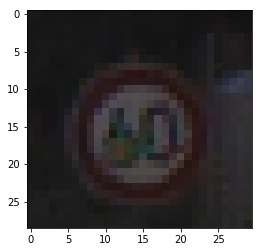

True :3.0
predicted:3.0

I think that belongs to class: 3.0


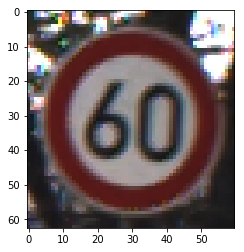

True :3.0
predicted:3.0

I think that belongs to class: 3.0


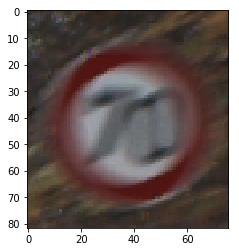

True :4.0
predicted:4.0

I think that belongs to class: 4.0


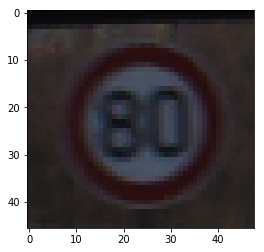

True :5.0
predicted:5.0

I think that belongs to class: 5.0


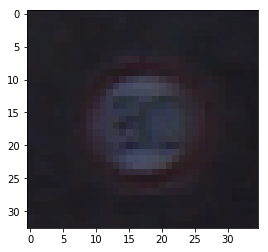

True :5.0
predicted:5.0

I think that belongs to class: 5.0


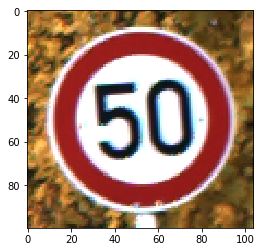

True :2.0
predicted:1.0

I think that belongs to class: 1.0


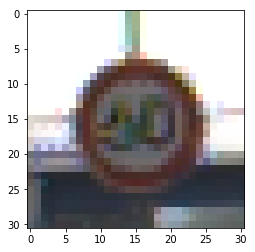

True :3.0
predicted:3.0

I think that belongs to class: 3.0


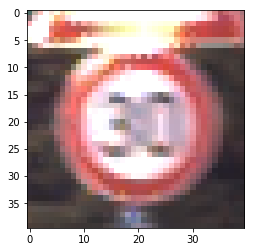

True :1.0
predicted:1.0

I think that belongs to class: 1.0


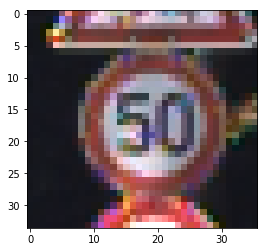

True :2.0
predicted:2.0

I think that belongs to class: 2.0


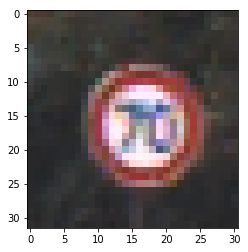

True :4.0
predicted:4.0

I think that belongs to class: 4.0
total time 13.3 seconds


In [22]:
start_time = datetime.datetime.now()
for i in range(10):
    testing_on_data("combine",'svm')
end_time = datetime.datetime.now()
dt = end_time - start_time
seconds = dt.total_seconds()
t = format_time(seconds)
print("total time",t)